In [1]:
import numpy as np
import pandas as pd
from os import listdir, mkdir
from os.path import isdir
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp

rcParams = {'font.size': 20, 
            'font.weight': 'normal', 
            'font.family': 'sans-serif',
            'axes.unicode_minus':False, 
            'axes.labelweight':'normal', 
            'xtick.labelsize' : 16,
            'ytick.labelsize' : 16}

plt.rcParams.update(rcParams)

def Compute_Query_Coverage(group):
    qstarts, qends = group['QStart'].tolist(), group['QEnd'].tolist()
    sstarts, sends = group['SStart'].tolist(), group['SEnd'].tolist()
    alignlengths = np.array(group['AlignLength'].tolist())
    pident = np.array(group['PIdent'].tolist())
    qlength = group.iloc[0]['QLen']
    slength = group.iloc[0]['SLen']
    presence = np.zeros(qlength)
    avg_pident = np.sum(np.multiply(alignlengths,pident))/np.sum(alignlengths)
    
    for i in range(len(qstarts)):
        presence[qstarts[i]:qends[i]] = 1
    qcov = np.sum(presence)/len(presence)*100
    
    presence = np.zeros(slength)
    for i in range(len(sstarts)):
        presence[sstarts[i]:sends[i]] = 1
    scov = np.sum(presence)/len(presence)*100  
    return pd.Series({'Qcov':qcov, 'Scov':scov, 'PIdent':avg_pident})

def Load_PAF(filepath, grouped = False):
    try:
        header = ['Query','QLen','QStart','QEnd','Orientation','Subject','SLen','SStart','SEnd',
                  'Matches','AlignLength','MAPQ','TP', 'MM', 'GN', 'GO', 'CG', 'CS']
        df = pd.read_csv(filepath, sep = "\t", names = header)
        
        df[['QLen','QStart','QEnd','SLen','SStart',
            'SEnd','Matches','AlignLength','MAPQ']] = df[['QLen','QStart','QEnd','SLen','SStart',
                                                          'SEnd','Matches','AlignLength','MAPQ']].astype('int')
        
        if grouped:
            df['PIdent'] = df['Matches']/df['AlignLength']*100
            df_grp = df.groupby(['Query','Subject']).apply(Compute_Query_Coverage)
            df_grp['Breadth_Coverage'] = df_grp[['Qcov', 'Scov']].max(axis = 1)
            return df_grp
        df['PIdent'] = df['AlignLength']/df['QLen']*100
        df = df.loc[df.groupby(['Query'])['PIdent'].idxmax()]
        df = df[['Query','QLen','PIdent']]
        df = df.rename(columns = {'Query':'Contig'})
        df = df.set_index('Contig')
        return df
    except KeyError:
        return pd.DataFrame()

def Plot_Box_Plots(boxes, positions, colors, ax, widths = 0.85, lw = 2.5, 
                   scatter = False, deviation = 0.045, s = 70, alpha = 0.1):
    flierprops = dict(marker='x', markersize=2.5, linestyle='none', color = 'gray')
    whiskerprops = dict(color='black',linewidth=1.5)
    capprops = dict(color='black', linewidth=1.5)
    medianprops = dict(linewidth=1.5, linestyle='-', color='black')
    meanprops = dict(markersize = 10, color = 'black')
    
    for i in range(0, len(positions)):
        box = ax.boxplot([boxes[i]], positions=[positions[i]], whis = [5,95], widths = [widths],
                         showfliers = True, boxprops = dict(linestyle='-', linewidth=lw, color=colors[i]), 
                         flierprops = flierprops, whiskerprops = whiskerprops, capprops = capprops, 
                         medianprops = medianprops, showmeans = True, meanprops = meanprops, )
    
    if(scatter):
        for i in range(0, len(positions)):
            y = boxes[i]
            x = np.random.normal(positions[i], deviation, size=len(y))
            ax.scatter(x,y,color = colors[i],alpha = alpha, marker = 'o', s = s)
            ax.scatter([positions[i]]*2, [max(y), min(y)], color = colors[i], marker = 'o', s = s)
            
def Load_Containment_Clusters(containment_cluster_path, genome):
    df_novel_contigs = pd.read_csv(containment_cluster_path, sep = "\t")
    op = []
    novel_contigs = list(set(df_novel_contigs['Contig'].tolist()))
    for n in novel_contigs:
        n = n.replace(genome, "Genome")
        splits = n.split('_')
        if len(splits) == 4:
            sample = splits[0]
            contig = splits[2]+'_'+splits[3]
            op.append((sample,contig))
        if len(splits) == 5:
            sample = splits[0] + '_' +splits[1]
            contig = splits[3]+'_'+splits[4]
            op.append((sample,contig))    
    return op

In [2]:
data_dir = '/Users/harihara/Mount-2/hotspring_metagenome/Synechococcus_paper_analysis/Hotsprings_Variant_Structure'
genomes = ['Aerophilum','Chloracidobacterium_thermophilum_B','Chloroflexus_MS_G','OSA','OSB','Roseiflexus']
novel_contigs_dir = data_dir+'_Data_Analysis/'

In [4]:
df_novel_read_counts = {}
df_non_novel_read_counts = {}

for g in genomes:
    df_orphaned_reads = pd.DataFrame()
    hotsprings = sorted(listdir(data_dir+'/'+g+'/'))
    for sample in hotsprings:
        if not sample.startswith("Hot"):
            continue
        try:
            df_read_counts = pd.read_csv(data_dir+'/'+g+'/'+sample+'/Differential_Read_Counting/'+g+'.Orphaned_Reads.Summary',
                                     sep = "\t", index_col = "Contig")
            df_paf = Load_PAF(data_dir+'/'+g+'/'+sample+'/reference_guided_scaffolds/Ref_Guided_Scaffolds.'+g+'.paf')
            df = df_read_counts.join(df_paf, how = 'left')
            df = df.reset_index()
            df['Sample'] = sample
            df['Genome'] = g
            df_orphaned_reads = df_orphaned_reads.append(df, ignore_index = True)
        except FileNotFoundError:
            print(sample, g)
    df_orphaned_reads = df_orphaned_reads.set_index(['Sample','Contig'])
    contigs_of_interest = Load_Containment_Clusters(novel_contigs_dir+g+'/containment_clusters.txt', g)
    print(g, len(contigs_of_interest), len(df_orphaned_reads))
    sel = df_orphaned_reads.loc[df_orphaned_reads.index.isin(contigs_of_interest)].copy()
    sel['Or_Ratio'] = (sel['Orphaned_Read_Flag(Aligned)']+sel['Orphaned_Read_Flag(Non-Aligned)'])/sel['Read']*100
    df_novel_read_counts[g] = sel
    sel = df_orphaned_reads.loc[~df_orphaned_reads.index.isin(contigs_of_interest)].copy()
    sel['Or_Ratio'] = (sel['Orphaned_Read_Flag(Aligned)']+sel['Orphaned_Read_Flag(Non-Aligned)'])/sel['Read']*100
    df_non_novel_read_counts[g] = sel.reset_index()

Aerophilum 7986 298869
Chloracidobacterium_thermophilum_B 8127 296693
Chloroflexus_MS_G 32734 541176
OSA 29950 607602
OSB 31239 1232032
Roseiflexus 129292 4808520


In [5]:
data_path = '/Users/harihara/Mount-2/hotspring_metagenome/Synechococcus_paper_analysis/\
Hotsprings_Variant_Structure_Data_Analysis/Synechococcus/Single_Cell_Analysis/'
files = listdir(data_path)
df_alignments = pd.DataFrame()
for f in files:
    if f.endswith(".paf"):
        df = Load_PAF(data_path+f, grouped=True)
        if len(df) <= 0:
            continue
        df = df[(df['Scov'] >= 95)]
        df = df.reset_index()
        df['Single_Cell_Sample'] = f.replace("_FD.paf","")
        df_alignments = df_alignments.append(df, ignore_index = True)
        
df_groups = pd.read_excel('/Users/harihara/Mount-2/hotspring_metagenome/Synechococcus_paper_analysis/\
Hotsprings_Variant_Structure_Data_Analysis/Synechococcus/Filtered.Eggnog.Annotations.xlsx')
df_groups = df_groups[['GroupID','RepresentativeContig']]
df_groups = df_groups.set_index(['RepresentativeContig'])
df_groups = df_groups.drop_duplicates()

df_filtered_alignments = df_alignments[df_alignments['PIdent'] > 0]
df_grp = df_filtered_alignments.groupby('Subject').count()[['Single_Cell_Sample']]
df_grp = df_grp.join(df_groups, how = 'inner')
df_grp = df_grp.set_index('GroupID')
df_grp['Single_Cell_Sample'] = df_grp['Single_Cell_Sample'].fillna(0)
df_grp = df_grp.sort_values(by = 'Single_Cell_Sample', ascending = False)

In [6]:
out_dir = '/Users/harihara/Research-Activities/Plots/Hot_Spring_Plots/Synechococcus-Paper-New-Plots/'
if not isdir(out_dir):
    mkdir(out_dir)

KeyError: 'QLen'

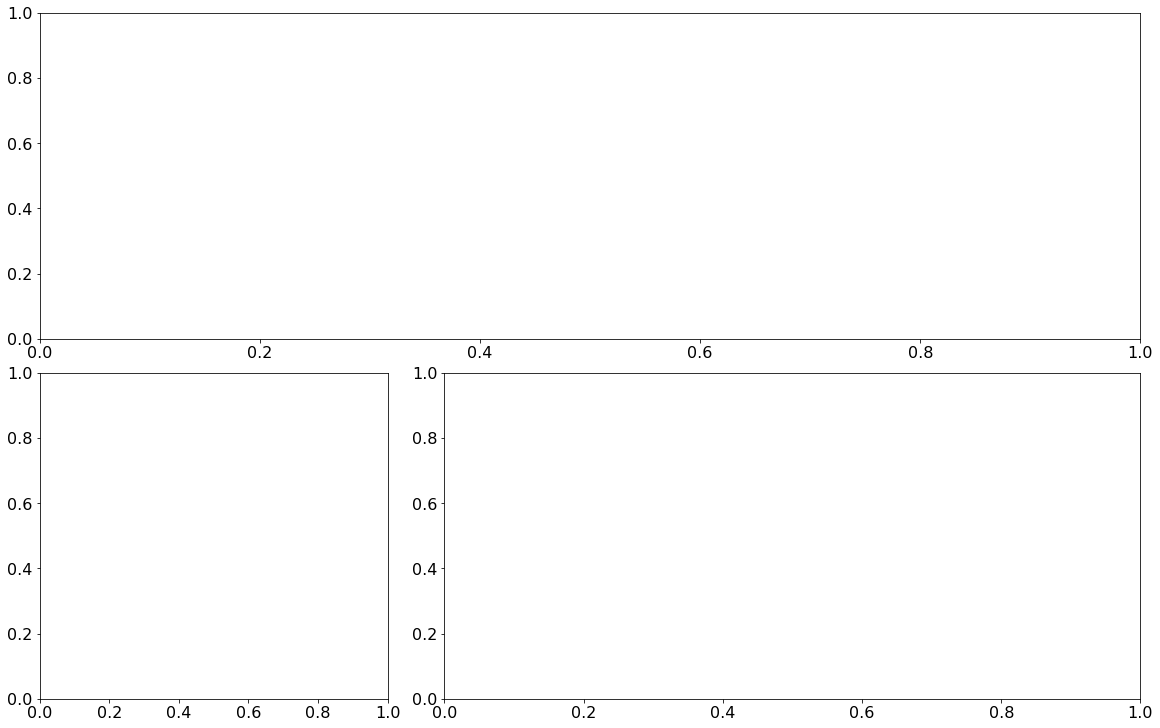

In [6]:
plt.rcParams.update(rcParams)

fig = plt.figure(constrained_layout = True,figsize = (16,10))
gs0 = fig.add_gridspec(2, 1,  height_ratios=[1,1])
gs1 = gs0[0].subgridspec(1, 1)
ax1 = fig.add_subplot(gs1[0])

gs2 = gs0[1].subgridspec(1, 2, width_ratios = [1,2])
ax2, ax3 = fig.add_subplot(gs2[0]), fig.add_subplot(gs2[1])

min_read_count = 20
gaps = 3.5
counter = 0

xticks = []
xtick_labels = ['Aerophilum', 'Chloracidobacterium\n Thermophilum B', 'Chloroflexus MS G', 'OSA', 'OSB', 
                'Roseiflexus']

for g in genomes:
    df_novel_filter = df_novel_read_counts[g]
    df_novel_filter = df_novel_filter.loc[(df_novel_filter['Read'] > min_read_count) & 
                                          (df_novel_filter['QLen'] > 500)]
    
    df_not_novel_filter = df_non_novel_read_counts[g]
    df_not_novel_filter = df_not_novel_filter.loc[(df_not_novel_filter['Read'] > min_read_count)&
                                                  (df_not_novel_filter['QLen'] > 500) &
                                                  (df_not_novel_filter['PIdent'] > 70)]# & 
    stat, p_val = ks_2samp(df_not_novel_filter['Or_Ratio'], df_novel_filter['Or_Ratio'])
    Plot_Box_Plots([df_novel_filter['Or_Ratio'], df_not_novel_filter['Or_Ratio']], [counter, counter + 1], 
                  ['C3', 'C4'], ax1, scatter = False)
    
    
    if p_val <= 0.005: ptext = r'p-value < 0.005'
    else: ptext = r'p-value > 0.005'
    ax1.text(counter+0.85/2, 105, r'KS-stat:'+str(round(stat, 2))+'\n'+ptext, ha = 'center', size = 16, fontstyle = 'italic')
    xticks.append(counter+0.5)
    counter += gaps
ax1.bar(-10,0,color = 'C3', label = 'Putative variant contigs')
ax1.bar(-10,0,color = 'C4', label = 'Non-variant contigs')
ax1.legend(ncol = 2, loc = 1, frameon = False)    
ax1.set_xticks(xticks)    
ax1.set_xticklabels(xtick_labels, rotation = 0)    
ax1.set_ylim([-5, 140])
ax1.axhline(120, color = 'black', linewidth = 0.5, linestyle = '-.')
ax1.set_yticks(range(0, 110, 20))
ax1.set_ylabel('Ratio of orphaned reads \n to all reads in the assembly')
ax1.set_xlim([-1.5, counter-1.5])

df_filtered_alignments[['PIdent']].plot(kind = 'hist', bins = 35, ax = ax2, histtype='step',
                                        linewidth=3, legend = False, color = 'black')
ax2.set_xlabel('Percent Identity')
ax2.set_ylabel('Distribution of percent identity \n in the alignments')

df_grp.plot(kind = 'bar', ax = ax3, legend = False,color = 'black')
ax3.set_ylabel('Number of Single Cell\n Assemblies')
ax3.set_xticks([])
ax3.set_xlabel('Putative Variant Groups')

#fig.tight_layout()
#fig.savefig(out_dir+'Orphaned_Reads_SAGs.pdf',bbox_inches='tight',facecolor = '#FFFFFF')

In [15]:
df_grp.loc['Group_1855']

Single_Cell_Sample    29
Name: Group_1855, dtype: int64